In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
# Import pyMC3 and also arviz for visualisation
import pymc as pm
import arviz as az
import sympy as sp
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('bmh')
import symseaman as ss
from symseaman.substitute_dynamic_symbols import lambdify, remove_bis_eq, run, standard_substitutes
from symseaman.seaman_symbols import *
from vct.bis_system import BisSystem

[03/09/23 13:24:27] WARNING  Using NumPy C-API based implementation for BLAS functions.        ]8;id=651834;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/pytensor/tensor/blas_headers.py\blas_headers.py]8;;\:]8;id=953386;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/pytensor/tensor/blas_headers.py#1016\1016]8;;\

In [3]:
def data_to_bis(df: pd.DataFrame, lpp_, disp_):
    units = {
        "fy_rudders": "force",
        "fy_rudder": "force",
        "tprop": "force",
    }
    bis_system = BisSystem(lpp=lpp_, volume=disp_, units=units)
    interesting = list(set(bis_system.qd.keys()) & set(df.columns))
    interesting += ["test type", "model_name", "fy_rudders", "fy_rudder", "tprop"]
    interesting = list(set(interesting))
    df_bis = bis_system.df_to_bis(df[interesting])
    return df_bis

In [4]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables['ships']

In [5]:
ships

['M5064-02-A']

In [6]:
%reload_kedro
ship='M5064-02-A'
df_VCT = catalog.load(f"{ship}.df_VCT")
df_VCT['tprop'] = df_VCT['thrust']
df_VCT['fy_rudder'] = df_VCT['fy_rudders'] = df_VCT['fy']

[03/09/23 13:24:39] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=948184;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=143892;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#132\132]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[03/09/23 13:24:40] INFO     Kedro project phd                                                      ]8;id=217060;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=979731;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#101\101]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=628699;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=400363;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#102\102]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from 'M5064-02-A.df_VCT' (CSVDataSet)...              ]8;id=803168;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=429912;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [7]:
df_VCT.head()

,index,Dp,S,V,beta,delta,fx,fy,fz,g,...,p,phi,model_name,test type,eta0,T_tot_net_force,method,tprop,fy_rudder,fy_rudders
0,\\sspa.local\linux\projects\proj2018\20188863-...,5.3,8245.480900,8.231111,0.0,-0.0,-54129.760606,-1.882611e+06,-8.886267e+06,9.80665,...,0,0,M5064-02-A,Circle,1.000007,9.471704e+05,virtual captive test,1.103928e+06,-1.882611e+06,-1.882611e+06
1,\\sspa.local\linux\projects\proj2018\20188863-...,5.3,8245.480900,8.231111,0.0,-0.0,33405.571316,-9.587846e+05,-7.943515e+06,9.80665,...,0,0,M5064-02-A,Circle,1.000007,9.460228e+05,virtual captive test,1.102591e+06,-9.587846e+05,-9.587846e+05
2,\\sspa.local\linux\projects\proj2018\20188863-...,5.3,8245.480900,8.231111,0.0,-0.0,51311.974521,-5.743306e+05,-7.739233e+06,9.80665,...,0,0,M5064-02-A,Circle,1.000007,9.628373e+05,virtual captive test,1.122188e+06,-5.743306e+05,-5.743306e+05
3,\\sspa.local\linux\projects\proj2018\20188863-...,5.3,8245.480900,8.231111,0.0,-0.0,40982.301461,-4.235769e+05,-7.635107e+06,9.80665,...,0,0,M5064-02-A,Circle,1.000007,9.489061e+05,virtual captive test,1.105951e+06,-4.235769e+05,-4.235769e+05
4,\\sspa.local\linux\projects\proj2018\20188863-...,5.3,8321.081275,11.317778,0.0,-0.0,122947.475954,-1.827642e+06,-1.530436e+07,9.80665,...,0,0,M5064-02-A,Circle,0.999983,1.780923e+06,virtual captive test,2.075668e+06,-1.827642e+06,-1.827642e+06


In [45]:
df_VCT['test type'].unique()

array(['Circle', 'Circle + Drift', 'Drift angle', 'Rudder angle',
       'Thrust variation', 'self propulsion'], dtype=object)

In [46]:
mask = df_VCT.columns.str.contains('fx')
df_VCT.columns[mask]

Index(['fx'], dtype='object')

In [47]:
df_VCT.columns

Index(['index', 'Dp', 'S', 'V', 'beta', 'delta', 'fx', 'fy', 'fz', 'g', 'lpp',
       'mx', 'my', 'mz', 'r', 'result_file_path', 'rho', 'rn', 'roll', 'u',
       'v', 'PROPLOG', 'rev', 'rev_p5095A', 'rev_p5095B', 'thrust',
       'thrust_p5095A', 'thrust_p5095B', 'torque', 'torque_p5095A',
       'torque_p5095B', 'name', 'path', 'p', 'phi', 'model_name', 'test type',
       'eta0', 'T_tot_net_force', 'method', 'tprop', 'fy_rudder',
       'fy_rudders'],
      dtype='object')

In [48]:
df_bis = data_to_bis(df=df_VCT, lpp_=224.5, disp_=31717.0)

In [49]:
df = df_bis.groupby('test type').get_group('Thrust variation')

<Axes: xlabel='thrust'>

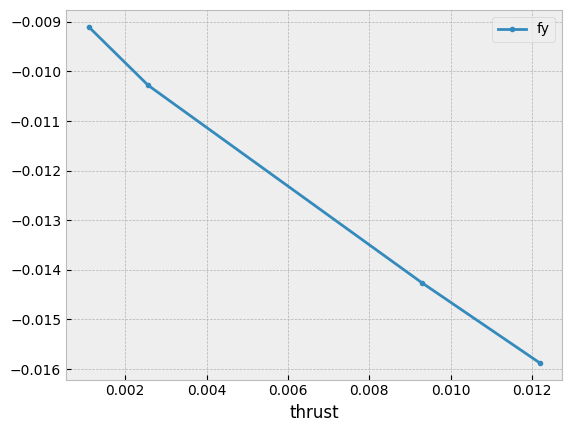

In [50]:
df.sort_values(by='delta').plot(x='thrust', y='fy', style='.-')

In [52]:
eq = ss.equations.rudder.sway.eq_expanded.subs([
    (r_w.bis,0),
    (v_w.bis,0),
    
])
remove_bis_eq(eq)

Eq(Y_rudder, (delta**2*s + 1)*(T_prop*Y_Tdelta*delta*(7.28*u_w + 1.0) + Y_uudelta*delta*u_w**2))

In [53]:
eq_thrust_variation = eq.subs([(Y_uudelta,0),])
eq_thrust_variation

Eq(Y''_rudder, delta*T''_prop*Y_Tdelta*(7.28*u''_w + 1.0)*(delta**2*s + 1))

In [54]:
lambda_fy_thrust_variation = lambdify(eq_thrust_variation, convert_to_SI=False)
lambda_fy_thrust_variation

<function _lambdifygenerated(delta, s, tprop, u, ytd)>

In [55]:
variables = [u_w.bis,T_prop.bis,delta,s]
eq = eq_thrust_variation
features = eq.rhs.free_symbols - set(variables)
A_,b_ = sp.linear_eq_to_matrix(eq, features)
A_

Matrix([[-delta*T''_prop*(7.28*u''_w + 1.0)*(delta**2*s + 1)]])

In [139]:
b_

Matrix([[-Y''_rudder]])

In [140]:
lambda_features = lambdify(A_, convert_to_SI=False)
lambda_labels = lambdify(b_, convert_to_SI=False)

In [141]:
lambda_features

<function _lambdifygenerated(delta, s, tprop, u)>

In [142]:
data = df
subs = standard_substitutes(features)
columns = [subs.get(feature,feature) for feature in features]

derivatives = {
    's':-0.9,
}

X = pd.DataFrame(run(function=lambda_features, inputs=data, **derivatives)[0].T, columns=columns, index=data.index)
X['const']=1.0
columns = list(X.columns)

In [143]:
X.head()

,ytd,const
30,0.000746,1.0
31,0.001735,1.0
32,0.006290,1.0
33,0.008249,1.0


In [144]:
y = -pd.Series(lambda_labels(data['fy']).flatten(), index=data.index)

In [145]:
y.head()

30   -0.009102
31   -0.010280
32   -0.014259
33   -0.015873
dtype: float64

In [146]:
model = sm.OLS(y,X)
regression = model.fit()
regression.summary()

[03/09/23 09:29:03] WARNING  /home/maa/dev/PHD/venv/lib/python3.10/site-packages/statsmodels/stats/ ]8;id=839512;file:///usr/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=710999;file:///usr/lib/python3.10/warnings.py#109\109]8;;\
                             stattools.py:74: ValueWarning: omni_normtest is not valid with less                   
                             than 8 observations; 4 samples were given.                                            
                               warn("omni_normtest is not valid with less than 8 observations; %i "                
                                                                                                                   

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1168.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           0.000855
Time:                        09:29:03   Log-Likelihood:                 30.611
No. Observations:                   4   AIC:                            -57.22
Df Residuals:                       2   BIC:                            -58.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ytd           -0.8919      0.026    -34.179      0.001      -1.004      -0.780
const         -0.0086      0.000    -62.390      0.000      -0.009      -0.008
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.133
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.406
Skew:                          -0.023   Prob(JB):                        0.816
Kurtosis:                       1.439   Cond. No.                         321.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [147]:
data['OLS'] = regression.predict(X)

In [149]:
mus = {
    'ytd':regression.params['ytd'],
    'const':regression.params['const'],
}

stds = {
    'ytd':regression.bse['ytd'],
    'const':regression.bse['const'],
    
}

sigma_ = 0.001*data['fy'].abs().max()


In [150]:
basic_model = pm.Model()

sigmas_ = [stds[key] for key in columns]
mus_ = [mus[key] for key in columns]

with basic_model:
    # Priors for unknown model parameters
    parameters = pm.Normal("parameters", mu=mus_, 
                           sigma=sigmas_, 
                           shape=len(mus))
    
    sigma = pm.HalfNormal("sigma", sigma=sigma_)

    # Expected value of outcome
    mu = pm.math.dot(X, parameters)

    # Likelihood (sampling distribution) of observations
    #fy_obs = pm.Normal("fy_obs", mu=mu, sigma=sigma, observed=data['fy_measure'])
    ν = pm.Uniform("ν", 1, 10)
    Y_obs = pm.StudentT("fy_obs", nu=ν, mu=mu, sigma=sigma, observed=y)
    

In [151]:
with basic_model:
    # draw 1000 posterior samples
    trace = pm.sample(draws=1000)

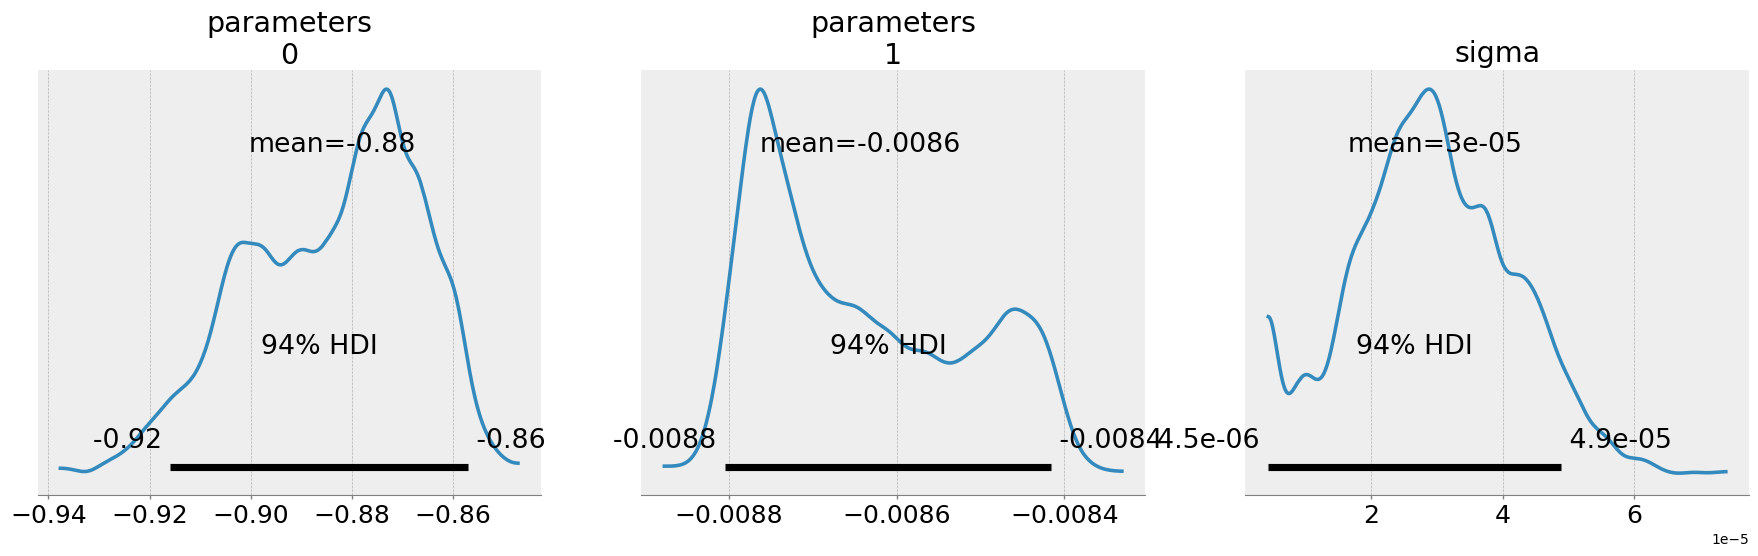

In [152]:
with basic_model:
    az.plot_posterior(trace,
                  var_names=['parameters','sigma'],
                  textsize=18,
                  point_estimate='mean',
                  rope_color='black')

In [153]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
parameters[0],-0.884,0.017,-0.916,-0.857,0.001,0.001,310.0,574.0,1.00
parameters[1],-0.009,0.000,-0.009,-0.008,0.000,0.000,275.0,748.0,1.00
sigma,0.000,0.000,0.000,0.000,0.000,0.000,98.0,37.0,1.02
ν,2.043,1.358,1.000,4.470,0.056,0.039,164.0,56.0,1.01


In [154]:
means = (trace.posterior['parameters'].data[0].mean(axis=0) + trace.posterior['parameters'].data[1].mean(axis=0))/2
means = {key:mean for key,mean in zip(columns,means)}

In [157]:
data['Bayesian'] = means['const'] - lambda_fy_thrust_variation(Y_td=means['ytd'], delta=data['delta'], T=data['tprop'])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ ❱ 1 data['Bayesian'] = means['const'] - lambda_fy_thrust_variation(Y_td=means['ytd'], delta=     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: _lambdifygenerated() got an unexpected keyword argument 'Y_td'

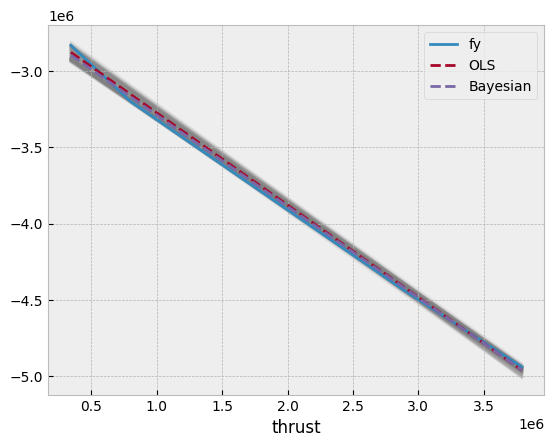

In [164]:
fig,ax=plt.subplots()
data.plot(x='thrust', y='fy', ax=ax)
data.plot(x='thrust', y='OLS', style='--', ax=ax)
data.plot(x='thrust', y='Bayesian', style='--', ax=ax)

for params in trace.posterior['parameters'][0].data[0::10]:
    param = {key:mean for key,mean in zip(columns,params)}
    ax.plot(data['thrust'], param['const'] - lambda_fy_thrust_variation(Y_td=param['Y_td'], delta=data['delta'], T=data['T']), alpha=0.1, color='grey', zorder=-10)